In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
os.chdir('/content/gdrive/MyDrive/bio')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path as path
%matplotlib inline

# Read data

In [ ]:
covid_path = path('/content/gdrive/MyDrive/bio/DatasetXray/COVID-19 Dataset/X-ray/COVID-19')
non_covid_path = path('/content/gdrive/MyDrive/bio/DatasetXray/COVID-19 Dataset/X-ray/LungNormal')
covid_image = os.listdir(covid_path)
non_covid_image = os.listdir(non_covid_path)
print(f'Number of COVID Images: {len(covid_image)} \nNumber of Non-COVID Images: {len(non_covid_image)}')

Number of COVID Images: 4044 
Number of Non-COVID Images: 5500


In [ ]:
covid_filepaths = [str(covid_path) + '/' + img_path for img_path in covid_image]
non_covid_filepaths = [str(non_covid_path) + '/' + img_path for img_path in non_covid_image]

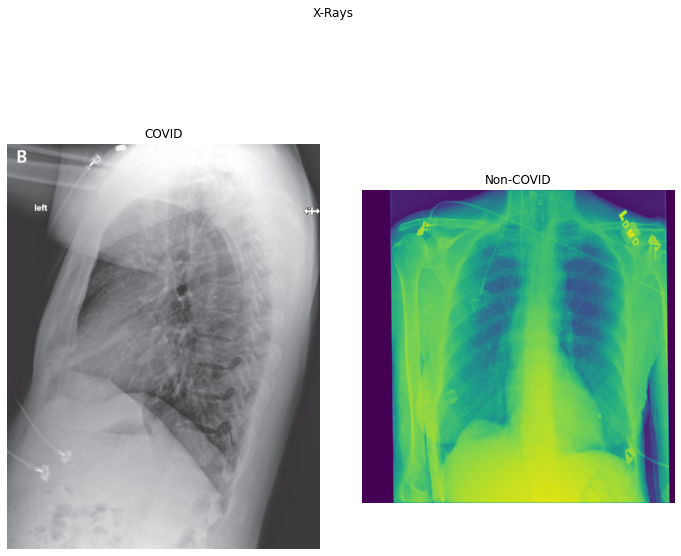

In [ ]:
# #all covid_images file (0-4043)
imgCovid = plt.imread(covid_filepaths[4043])
# plt.imshow(imgCovid)
# plt.show()
# #all non_covid_images file (0-5499)
imgNon = plt.imread(non_covid_filepaths[5499])
# plt.imshow(imgNon)
# plt.show()
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=[10,10])
fig.tight_layout()
axs[0].imshow(imgCovid)
axs[0].set_title('COVID')
axs[0].axis('off')
axs[1].imshow(imgNon)
axs[1].set_title('Non-COVID')
axs[1].axis('off')
fig.suptitle('X-Rays')
plt.show()

# Processing data and Create Daataframe

In [ ]:
#Processing (create dataframe)
def proces_img(filepath):
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
covid_df = proces_img(covid_filepaths)
covid_df.head(1)

,Filepath,Label
0,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19


In [ ]:
normal_df = proces_img(non_covid_filepaths)
normal_df.head(1)

,Filepath,Label
0,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,LungNormal


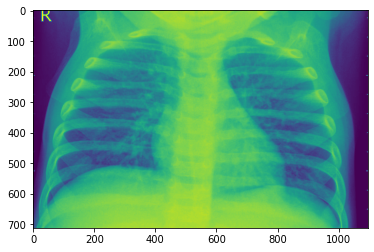

In [ ]:
imgCovid = plt.imread(covid_df.Filepath[1])
plt.imshow(imgCovid)
plt.show()

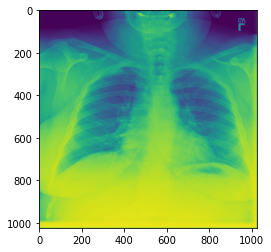

In [ ]:
imgNormal = plt.imread(normal_df.Filepath[1])
plt.imshow(imgNormal)
plt.show()

In [ ]:
#Concat Dataframe
df = pd.concat([covid_df, normal_df], axis=0)
df.head(5)

,Filepath,Label
0,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19
1,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19
2,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19
3,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19
4,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,COVID-19


In [ ]:
df.tail(1)

,Filepath,Label
5499,/content/gdrive/MyDrive/bio/DatasetXray/COVID-...,LungNormal


In [ ]:
df.Label.value_counts()

LungNormal    5500
COVID-19      4044
Name: Label, dtype: int64

In [ ]:
len(df.Label)

9544

# Splitting data set

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df.index,stratify=df.Label, test_size = 0.3)
train_df = df.loc[train]
test_df = df.loc[test]

In [ ]:
print(f'Size of training set is: {train.shape[0]} images')
print(f'Size of test set is: {test.shape[0]} images')
train_df.Label.value_counts(normalize=True)

Size of training set is: 6680 images
Size of test set is: 2864 images


LungNormal    0.5419
COVID-19      0.4581
Name: Label, dtype: float64

# Image Generator

In [ ]:
#image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rescale=1./255
)
test_images = train_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 10 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 12317 validated image filenames belonging to 2 classes.
Found 5302 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Model CNN

In [ ]:
#model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten

## Create Sequential Model

In [ ]:
# Create Sequential Model
model = Sequential()
# Layer 1: Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(4,4), input_shape=(120,120,1), activation='relu',))
# Layer 2: Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))
# Layer 3: Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(4,4), input_shape=(120,120,1), activation='relu',))
# Layer 4: Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))
# Layer 5: Flatten Layer
model.add(Flatten())
# Layer 6: Dense Layer (Hidden Layer)
model.add(Dense(256, activation='relu'))
# Layer 7: Dense Layer (Output Layer)
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 117, 117, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 58, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

## Stop training when a monitored metric has stopped improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## Train model

In [ ]:
model.fit(train_images, epochs = 15 , validation_data = test_images, verbose=1, callbacks=early_stop)

Epoch 1/15
385/385 [==============================] - 2741s 7s/step - loss: 0.5493 - accuracy: 0.7093 - val_loss: 0.4478 - val_accuracy: 0.7827
Epoch 2/15
385/385 [==============================] - 891s 2s/step - loss: 0.4222 - accuracy: 0.8021 - val_loss: 0.3842 - val_accuracy: 0.8257
Epoch 3/15
385/385 [==============================] - 894s 2s/step - loss: 0.3644 - accuracy: 0.8313 - val_loss: 0.3524 - val_accuracy: 0.8387
Epoch 4/15
385/385 [==============================] - 887s 2s/step - loss: 0.3295 - accuracy: 0.8474 - val_loss: 0.3565 - val_accuracy: 0.8257
Epoch 5/15
385/385 [==============================] - 893s 2s/step - loss: 0.3006 - accuracy: 0.8638 - val_loss: 0.2972 - val_accuracy: 0.8697
Epoch 6/15
385/385 [==============================] - 884s 2s/step - loss: 0.2772 - accuracy: 0.8772 - val_loss: 0.2676 - val_accuracy: 0.8891
Epoch 7/15
385/385 [==============================] - 887s 2s/step - loss: 0.2598 - accuracy: 0.8889 - val_loss: 0.2573 - val_accuracy: 0.889

In [ ]:
model.save('my_model.h5')

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.549289,0.709345,0.447849,0.782723
1,0.422183,0.802143,0.384230,0.825726
2,0.364353,0.831290,0.352391,0.838740
3,0.329545,0.847447,0.356503,0.825726
4,0.300620,0.863766,0.297211,0.869672
5,0.277248,0.877162,0.267628,0.889098
6,0.259829,0.888934,0.257332,0.889664
7,0.241389,0.893237,0.267302,0.885892
8,0.231712,0.898352,0.245720,0.894191
9,0.215577,0.904685,0.234562,0.900792


# Plot Accuracy

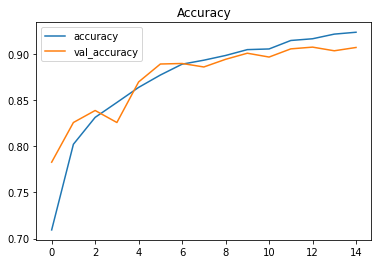

In [ ]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()      

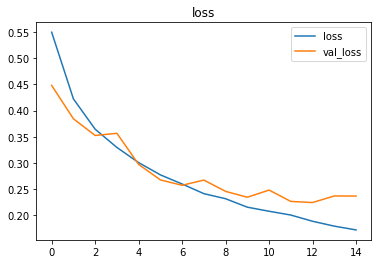

In [ ]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("loss") 
plt.show()      

# Load model

In [ ]:
# from keras.models import load_model
# model = load_model('my_model.h5')

# Predict

In [ ]:
# predict = "image(dataframe)"

# predict_generator = ImageDataGenerator(
#     preprocessing_function= preprocess_input,
#     rescale=1./255
# )
# predict_images = train_generator.flow_from_dataframe(
#     dataframe = predict,
#     x_col='Filepath',
#     y_col='Label',
#     target_size=(120, 120),
#     color_mode='grayscale',
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=0,
#     subset='training',
#     rotation_range=30,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode="nearest"
# )

In [ ]:
# model.predict_classes(predict_image)